# Introduction

In the previous notebook, Fourier transform was performed for all sensors and all cycles in two approaches. This resulted with amplitudes, phases and their uncertainties. For simplicity, the focus will be on the amplitudes and their standard squared uncertainties. Amplitudes and uncertainties have been saved into .hdf5 file, which will be read in one of the next cells. Then the aim is to calculate the means of all amplitudes at given frequencies (columns) and to choose % of the spectrum with the highest average. Further regression results will be presented for:
Further regression results will be presented for:
-	Padding based on cubic spline interpolation and zero padding (24 sensors, 23 853 points in time domain. Sampling period is T= 0.01 s, number of cycles is 81)
-	Sensors divided into two groups: 
       
       o	Heating sensors (3 sensors, 10 997 points in time domain. Sampling period is T= 0.01 s, number of cycles is 81)
       
       o	Forging sensors ( 21 sensors, 5619 points in time domain. Sampling period is T= 0.01 s, number of cycles is 81)


In [ ]:
import pandas as pd 
import time
# %pip install openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
#%matplotlib inline
import matplotlib as mpl
import numpy as np
np.random.seed(42)
from scipy.signal import find_peaks
from scipy import integrate
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from matplotlib._png import read_png
from matplotlib.cbook import get_sample_data
import h5py
import PyDynamic
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
#%pip install pymc3
import pymc3 as pm
#%pip install arviz
import arviz

font = {'family' : 'Times New Roman', 'weight' : 'normal', 'size'   : 20}
mpl.rcParams['figure.figsize'] = (20,10)
mpl.rc('font', **font)

Read the file for the case you want to observe:

In [ ]:
hf_a = h5py.File('Amplitudes_zero.hdf5', 'r')
hf_uap=h5py.File('Uncertainties_zero.hdf5', 'r')

In [ ]:
hf_a = h5py.File('Amplitudes_spl.hdf5', 'r')
hf_uap=h5py.File('Uncertainties_spl.hdf5', 'r')

In [ ]:
hf_a = h5py.File('Amplitudes_forged.hdf5', 'r')
hf_uap=h5py.File('Uncertainties_forged.hdf5', 'r')

In [ ]:
hf_a = h5py.File('Amplitudes_heated.hdf5', 'r')
hf_uap=h5py.File('Uncertainties_heated.hdf5', 'r')

In [ ]:
A_df=[None]*len(hf_a)
UAP_df=[None]*len(hf_a)
for i in range(len(hf_a)):
    A_df[i]=hf_a["A_df"+str(i)]
    UAP_df[i]=hf_uap["UAP"+str(i)]
    A_df[i]=pd.DataFrame(A_df[i])
    UAP_df[i]=pd.DataFrame(UAP_df[i])

In this part, the aim is to calculate the means of all amplitudes at given frequencies (columns) and to choose % of the spectrum with the highest average. This will be done with the function `sort_amplitudes_and_uncertainties`. It will sort the amplitudes´ columns in descending order, according to their means. The number of columns of amplitudes corresponds also to the number of columns of their standard squared uncertainties in UAP. Phases will be sorted in a way to follow the amplitudes.

The length of time signals with padded values is 23 853 (number of points) and sampling period is 0.01 s.
The length of time signals for forging sensors is 5 619 and for heating sensors is 10 997. Depending on the case you observe, choose the corresponding cell. 

In [ ]:
#padding
n_of_sampling_pts=23853
sample_period=0.01
time=0.01*n_of_sampling_pts# number of sampling points
time_steps=np.arange(0, time, 0.01)  
freq=PyDynamic.uncertainty.propagate_DFT.GUM_DFTfreq(n_of_sampling_pts,float(time)/n_of_sampling_pts)

In [ ]:
#forging
n_of_sampling_pts=5619
sample_period=0.01
time=0.01*n_of_sampling_pts# number of sampling points
time_steps=np.arange(0, time, 0.01)  
freq=PyDynamic.uncertainty.propagate_DFT.GUM_DFTfreq(n_of_sampling_pts,float(time)/n_of_sampling_pts)

In [ ]:
#heating
n_of_sampling_pts=10997
sample_period=0.01
time=0.01*n_of_sampling_pts# number of sampling points
time_steps=np.arange(0, time, 0.01)  
freq=PyDynamic.uncertainty.propagate_DFT.GUM_DFTfreq(n_of_sampling_pts,float(time)/n_of_sampling_pts)

In [ ]:
def sort_amplitudes_and_uncertainties (N,Amp,U,freq):

    Amp.columns = freq                    # Column labels are frequencies. 
    n_rows, n_columns=Amp.shape
    print("\nNumber of cycles is: %s, and number of features is: %s" % (n_rows, n_columns))
    # Calculating the average of absolute values for each frequency (column).
    average_values_from_columns=(Amp.mean())
    # Sorting column indices in amplitudes for sorting phases and uncertainties
    sorted_columns=np.argsort(average_values_from_columns)[::-1]
    # Columns indices(len(a):3*len(a) to follow the sorting)
    sorted_columns_unc_ap=(sorted_columns+Amp.shape[1])
    sorted_columns_unc_pp=(sorted_columns+Amp.shape[1]*2)
    sorted_columns_unc=np.concatenate((sorted_columns,sorted_columns_unc_ap,sorted_columns_unc_pp))#sorted indices for uncertainties
    # Reindexing all matrices based on columns.
    Amp=Amp.reindex(Amp.mean().sort_values(ascending=False).index, axis=1)
    
    c=U.reindex(columns=sorted_columns_unc)
    
    
    # Taking first N percent columns from sorted amplitudes,phases and ucertainties. 
    sorted_values_amp=Amp.iloc[:,:N]
    sorted_values_uncert_aa=c.iloc[:,:N]
    sorted_values_uncert_ap=c.iloc[:,len(freq):Amp.shape[1]+N]
    sorted_values_uncert_pp=c.iloc[:,2*len(freq):Amp.shape[1]*2+N]        
                                         
    n_rows, n_columns = np.shape(sorted_values_amp)
    print("\nNumber of cycles is: %s, and number of selected features is: %s" % (n_rows, n_columns))
    print(np.shape(sorted_values_amp))
    
    # Informations about the selected frequencies are columns in sorted data frame. 
    freq_of_sorted_values=(pd.DataFrame(sorted_values_amp.columns)).transpose()
    print("\nFirst 200 selected frequencies are:\n\n %s" % freq_of_sorted_values.values[:,:N])
    
    # Resetting the column labels.
    sorted_values_amp.columns=range(N)
    
    sorted_values_uncert_aa.columns=range(N)
    sorted_values_uncert_ap.columns=range(N)
    sorted_values_uncert_pp.columns=range(N)
    
    

    print("---------------------------------------------------------------------------------\n")
    # Output "sorted_values_matrix" is data frame whose rows-
    # -are cycles and columns are selected frequencies. For example,- 
    # -value at position (i,j) is amplitude for frequency j in cycle i.
    return freq_of_sorted_values,sorted_values_amp,sorted_values_uncert_aa, sorted_values_uncert_ap,sorted_values_uncert_pp
    

##### Function execution

In [ ]:
percentage=input("Enter the percentage of spectrum to be sorted:")
N=(round((float(percentage)/100)*A_df[0].shape[1]))
freq_of_sorted_values=[None]*len(hf_a)
sorted_values_amp=[None]*len(hf_a)
sorted_values_uncert_aa=[None]*len(hf_a)
sorted_values_uncert_ap=[None]*len(hf_a)
sorted_values_uncert_pp=[None]*len(hf_a)
for i in range(len(hf_a)):
    print("Sensor:",i)
    freq_of_sorted_values[i],sorted_values_amp[i],sorted_values_uncert_aa[i],sorted_values_uncert_ap[i],sorted_values_uncert_pp[i] =sort_amplitudes_and_uncertainties(N,A_df[i],UAP_df[i],freq)


##### An overwiev of the results:

In [ ]:
freq_of_sorted_values[0]

In [ ]:
sorted_values_amp[0].head(2)

In [ ]:
sorted_values_uncert_aa[1].head(5)

In [ ]:
sorted_values_uncert_ap[0].head(2)

In [ ]:
sorted_values_uncert_pp[0].head(2)

Then, an arbitrary column of measured data for all parts will be taken (because of simplicity) from the file CMMData.xlsx. For example, it will be 38 dia @200 (external diameter at 200 mm from the left).

In [ ]:
measured_part=pd.read_excel(Path('Data')/'AFRC Radial Forge - Zenodoo Upload v3'/'CMMData.xlsx')

In [ ]:
measured_part.head()

First three columns of `measured_part` are the nominal value and tolerances. These will be dropped, because only measured data of the parts is needed.

In [ ]:
target200=measured_part.iloc[3:,6]

# Weighted least squares

The method of least squares is a procedure to determine the best fit line to data.
The linear regression equation is:

$$E(y) = {β}_{0} + {β}_{1}x_{1} + {β}_{2}x_{2} + · · · + {β}_{k} x_{k}$$

where y denotes dependent and ${x}_{1}.....{x}_{k}$ independent variables. Finding the best fit means to estimate the coefficients ${β}_{1}.....{β}_{k}$  by minimizing the sum of squared residuals:
$$SSE = \sum_{i=1}^{n}[y_{i}-(\hat{β}_{0} + \hat{β}_{1}x_{1} + \hat{β}_{2}x_{2} + · · · + \hat{β}_{k} x_{k})]^2$$

Sometimes it is possible to give to some observations more weight than others. It can be achieved by specifying weights and then by minimizing a weighted sum of squares:

$$WSSE=\sum_{i=1}^{n}w_{i}[y_{i}-(\hat{β}_{0} + \hat{β}_{1}x_{1} + \hat{β}_{2}x_{2} + · · · + \hat{β}_{k} x_{k})]^2$$

The resulting β's are called weighted least squares (WLS) estimates, and the WLS residuals are:

$$\sqrt{y_{i}-\hat{y_{i}}}$$ []

10% of the spectrum with highest average of amplitudes (columns in *sorted_values_amp*) will be analyzed through WLS method. Reciprocal values of standard squared uncertainties (variances - columns in *sorted_value_uncert_aa*) will be used as weights $w_{i}$:

$$w_{i}=\frac{1}{{u_{A}}^2}$$

It is necessary to note that this will be done for the case of white noise where only diagonal elements in matrix of uncertainties are non-zero values (variances) and then weights will bevalues of column vector $W$  In general, if weights are a matrix, a weighted total least-squares algorithm should be considered. *Check References [8] and [9].*

In [ ]:
Amp_corr=[None]*len(sorted_values_amp)
UA_corr=[None]*len(sorted_values_uncert_aa)
for i in range(len(sorted_values_amp)):
    Amp_corr[i]=sorted_values_amp[i]
    UA_corr[i]=sorted_values_uncert_aa[i]

In [ ]:
X=[None]*len(sorted_values_amp)
UX=[None]*len(sorted_values_uncert_aa)
for i in range(len(sorted_values_amp)):
    X[i]=Amp_corr[i].copy()
    UX[i]=UA_corr[i].copy()

In [ ]:
#forging sensors names
list2=['Power [kW]', 'Force [kN]', 'A_ges_vibr','Schlagzahl [1/min]', 'RamRetract_ActSpd [rpm]',
       'A_ACTpos [mm]', 'L_ACTpos [mm]', 'R_ACTpos [mm]',
       'SBA_ActPos [mm]', 'A_ACT_Force [kN]', 'DB_ACT_Force [kN]',
       'L_NOMpos [mm]', 'R_NOMpos [mm]', 'INDA_NOMpos [deg]',
       'A_NOMpos [mm]', 'Frc_Volt','ForgingBox_Temp', 'L1.R_B41 [bar]', 'TMP_Ind_F [°C]','W2 Durchfluss [l]', 'W1 Durchfluss [l]']

In [ ]:
#heating sensors names
list3=['TMP_Ind_U1 [°C]','IP_ActPos [mm]', 'IP_NomPos']

With WLS, values of external diameter 200 mm from the left will be predicted. In order to do so, data will be split into train and test. WLS model will fit the train data and will be tested on test data.

In [ ]:
target=pd.read_excel(Path('Data')/'AFRC Radial Forge - Zenodoo Upload v3'/'Data'/'CMMData.xlsx', index_col=3)
target=target.drop(columns=['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2'])
#target.index

nominal_val=pd.DataFrame(target.iloc[0:3,:])
target=target.iloc[3:,:]
#Path('Data')/'AFRC Radial Forge - Zenodoo Upload v3'/'Data'/file_format

In [ ]:
y=target['38 dia @200'].values
y=pd.DataFrame(y)
y.columns=["Diameter"]

In [ ]:
k = int(input("Enter the percentage which will be used as a traning data: "))
y_train, y_test=train_test_split(y, test_size=1-k/100., random_state=42)

print("\nNumber of cycles selected for traning is: ", y_train.shape[0],",")
print("and number of cycles selected for testing is: ", y_test.shape[0])

In [ ]:
X_train=[0]*len(sorted_values_amp)
X_test=[0]*len(sorted_values_amp)
UX_train=[0]*len(sorted_values_amp)
UX_test=[0]*len(sorted_values_amp)

for i in range(len(sorted_values_amp)):
    X_train[i]=X[i].loc[y_train.index,:]
    UX_train[i]=UX[i].loc[y_train.index,:]
print("Traning data for one sensor has dimensions: ",  X_train[0].shape,",      ('X_train') ")
print("and it's target vector has length: ", y_train.shape,",               ('y_train') \n")

for i in range(len(sorted_values_amp)):
    X_test[i]=X[i].loc[y_test.index,:]
    UX_test[i]=UX[i].loc[y_test.index,:]
print("Testing data for one sensor has dimensions: ", X_test[0].shape,",      ('X_train') ")
print("and it's target vector has length: ", y_train.shape,",               ('y_train') \n")

In [ ]:
model_wls=[None]*len(X_train)
from sklearn.linear_model import LinearRegression
for i in range(len(X_train)):
    model_wls[i]=LinearRegression()
    model_wls[i].fit(X_train[i],y_train, sample_weight=1./(UX_train[i][0].values))


In [ ]:
print('WLS')
print(model_wls[1].intercept_, model_wls[1].coef_)

In [ ]:
model_wls[1].intercept_.mean()

In [ ]:
model_wls[1].coef_

R^2 (coefficient of determination) regression score function.
Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse).

The Mean Squared Error (MSE) or Mean Squared Deviation (MSD) of an estimator measures the average of error squares i.e. the average squared difference between the estimated values and true value. It is a risk function, corresponding to the expected value of the squared error loss. It is always non – negative and values close to zero are better. 


In [ ]:
#spline
from sklearn import metrics 
from sklearn.metrics import r2_score
y_predicted = [None]*len(model_wls)
num_of_sensor=['Power [kW]', 'Force [kN]', 'A_ges_vibr', 'Schlagzahl [1/min]','A_ACTpos [mm]', 'L_ACTpos [mm]', 'R_ACTpos [mm]','SBA_ActPos [mm]', 'A_ACT_Force [kN]', 'DB_ACT_Force [kN]','L_NOMpos [mm]', 'R_NOMpos [mm]', 'INDA_NOMpos [deg]','A_NOMpos [mm]', 'Frc_Volt', 'IP_ActPos [mm]', 'IP_NomPos','RamRetract_ActSpd [rpm]', 'ForgingBox_Temp', 'TMP_Ind_U1 [°C]','TMP_Ind_F [°C]', 'W2 Durchfluss [l]', 'W1 Durchfluss [l]','L1.R_B41 [bar]']
for i in range((len(model_wls))):
    y_predicted[i]=model_wls[i].predict(X_test[i])
    #check sample weight
    print("R score for the sensor",num_of_sensor[i],"is:", r2_score(y_test,y_predicted[i],sample_weight=1./(UX_test[i][0].values)),"and MSE error is:", metrics.mean_squared_error(y_test, y_predicted[i]))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
def sensor_predict(i):
    plt.figure(figsize=(15,7))
    plt.plot(np.arange(0,len(y_test),1),y_test,'o',label="True",)
    plt.plot(np.arange(0,len(y_test),1),y_predicted[i],'x',label ="Predicted")
    plt.axhline(y=38,label="Nominal value",color="red")
    plt.legend()
    num_of_sensor=['Power [kW]', 'Force [kN]', 'A_ges_vibr', 'Schlagzahl [1/min]','A_ACTpos [mm]', 'L_ACTpos [mm]', 'R_ACTpos [mm]','SBA_ActPos [mm]', 'A_ACT_Force [kN]', 'DB_ACT_Force [kN]','L_NOMpos [mm]', 'R_NOMpos [mm]', 'INDA_NOMpos [deg]','A_NOMpos [mm]', 'Frc_Volt', 'IP_ActPos [mm]', 'IP_NomPos','RamRetract_ActSpd [rpm]', 'ForgingBox_Temp', 'TMP_Ind_U1 [°C]','TMP_Ind_F [°C]', 'W2 Durchfluss [l]', 'W1 Durchfluss [l]','L1.R_B41 [bar]']
    plt.xlabel("Test data") 
    plt.ylabel("External diameter [mm]") 
    plt.title(num_of_sensor[i])

interact(sensor_predict,i=widgets.IntSlider(min=0, max=24, step=1))    

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,15))
plt.plot(np.arange(0,len(y_test),1),y_test,label="True")
for i in range (len(y_predicted)):
    plt.plot(np.arange(0,len(y_test),1),y_predicted[i],label ="Predicted" +num_of_sensor[i])
    
num_of_sensor=['Power [kW]', 'Force [kN]', 'A_ges_vibr', 'Schlagzahl [1/min]','A_ACTpos [mm]', 'L_ACTpos [mm]', 'R_ACTpos [mm]','SBA_ActPos [mm]', 'A_ACT_Force [kN]', 'DB_ACT_Force [kN]','L_NOMpos [mm]', 'R_NOMpos [mm]', 'INDA_NOMpos [deg]','A_NOMpos [mm]', 'Frc_Volt', 'IP_ActPos [mm]', 'IP_NomPos','RamRetract_ActSpd [rpm]', 'ForgingBox_Temp', 'TMP_Ind_U1 [°C]','TMP_Ind_F [°C]', 'W2 Durchfluss [l]', 'W1 Durchfluss [l]','L1.R_B41 [bar]']
 
plt.ylabel("External diameter [mm]") 
plt.legend()
mpl.rcParams["legend.loc"] = 'best'


In [ ]:
#zero
from sklearn import metrics 
from sklearn.metrics import r2_score
y_predicted_zero = [None]*len(model_wls)
num_of_sensor=['Power [kW]', 'Force [kN]', 'A_ges_vibr', 'Schlagzahl [1/min]','A_ACTpos [mm]', 'L_ACTpos [mm]', 'R_ACTpos [mm]','SBA_ActPos [mm]', 'A_ACT_Force [kN]', 'DB_ACT_Force [kN]','L_NOMpos [mm]', 'R_NOMpos [mm]', 'INDA_NOMpos [deg]','A_NOMpos [mm]', 'Frc_Volt', 'IP_ActPos [mm]', 'IP_NomPos','RamRetract_ActSpd [rpm]', 'ForgingBox_Temp', 'TMP_Ind_U1 [°C]','TMP_Ind_F [°C]', 'W2 Durchfluss [l]', 'W1 Durchfluss [l]','L1.R_B41 [bar]']
for i in range((len(model_wls))):
    y_predicted_zero[i]=model_wls[i].predict(X_test[i])
    #check sample weight
    print("R score for the sensor",num_of_sensor[i],"is:", r2_score(y_test,y_predicted_zero[i],sample_weight=1./(UX_test[i][0].values)),"and MSE error is:", metrics.mean_squared_error(y_test, y_predicted[i]))

In [ ]:
#zero
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
def sensor_predict(i):
    plt.figure(figsize=(15,7))
    plt.plot(np.arange(0,len(y_test),1),y_test,'o',label="True",)
    plt.plot(np.arange(0,len(y_test),1),y_predicted_zero[i],'x',label ="Predicted")
    plt.axhline(y=38,label="Nominal value",color="red")
    plt.legend()
    num_of_sensor=['Power [kW]', 'Force [kN]', 'A_ges_vibr', 'Schlagzahl [1/min]','A_ACTpos [mm]', 'L_ACTpos [mm]', 'R_ACTpos [mm]','SBA_ActPos [mm]', 'A_ACT_Force [kN]', 'DB_ACT_Force [kN]','L_NOMpos [mm]', 'R_NOMpos [mm]', 'INDA_NOMpos [deg]','A_NOMpos [mm]', 'Frc_Volt', 'IP_ActPos [mm]', 'IP_NomPos','RamRetract_ActSpd [rpm]', 'ForgingBox_Temp', 'TMP_Ind_U1 [°C]','TMP_Ind_F [°C]', 'W2 Durchfluss [l]', 'W1 Durchfluss [l]','L1.R_B41 [bar]']
    plt.xlabel("Test data") 
    plt.ylabel("External diameter [mm]") 
    plt.title(num_of_sensor[i])

interact(sensor_predict,i=widgets.IntSlider(min=0, max=24, step=1))    

In [ ]:
#heating
from sklearn import metrics 
from sklearn.metrics import r2_score
y_predicted_heating = [None]*len(model_wls)
num_of_sensor=list3
for i in range((len(model_wls))):
    y_predicted_heating[i]=model_wls[i].predict(X_test[i])
    #check sample weight
    print("R score for the sensor",num_of_sensor[i],"is:", r2_score(y_test,y_predicted_heating[i],sample_weight=1./(UX_test[i][0].values)),"and MSE error is:", metrics.mean_squared_error(y_test, y_predicted[i]))

In [ ]:
#forging
from sklearn import metrics 
from sklearn.metrics import r2_score
y_predicted_forging = [None]*len(model_wls)
num_of_sensor=list2
for i in range((len(model_wls))):
    y_predicted_forging[i]=model_wls[i].predict(X_test[i])
    #check sample weight
    print("R score for the sensor",num_of_sensor[i],"is:", r2_score(y_test,y_predicted_forging[i],sample_weight=1./(UX_test[i][0].values)),"and MSE error is:", metrics.mean_squared_error(y_test, y_predicted[i]))

In [ ]:
#forging
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
def sensor_predict(i):
    plt.figure(figsize=(15,7))
    plt.plot(np.arange(0,len(y_test),1),y_test,'o',label="True",)
    plt.plot(np.arange(0,len(y_test),1),y_predicted_forging[i],'x',label ="Predicted")
    plt.axhline(y=38,label="Nominal value",color="red")
    plt.legend()
    num_of_sensor=['Power [kW]', 'Force [kN]', 'A_ges_vibr', 'Schlagzahl [1/min]','A_ACTpos [mm]', 'L_ACTpos [mm]', 'R_ACTpos [mm]','SBA_ActPos [mm]', 'A_ACT_Force [kN]', 'DB_ACT_Force [kN]','L_NOMpos [mm]', 'R_NOMpos [mm]', 'INDA_NOMpos [deg]','A_NOMpos [mm]', 'Frc_Volt', 'IP_ActPos [mm]', 'IP_NomPos','RamRetract_ActSpd [rpm]', 'ForgingBox_Temp', 'TMP_Ind_U1 [°C]','TMP_Ind_F [°C]', 'W2 Durchfluss [l]', 'W1 Durchfluss [l]','L1.R_B41 [bar]']
    plt.xlabel("Test data") 
    plt.ylabel("External diameter [mm]") 
    plt.title(num_of_sensor[i])

interact(sensor_predict,i=widgets.IntSlider(min=0, max=24, step=1))    

# Monte Carlo method for the least squares

The idea of Monte Carlo (MC) method is to draw random samples of input quantities from their probability density functions (PDFs). For each of the *M* draws, the model between output and input quantities is evaluated for all input quantities. The result of the MC is the estimate of the output quantity and the associated standard uncertainty: 

- best estimate $\mathbf{y}$,is calculated as the mean value of all evaluations of the model (one sample, one evaluation - trial):
\begin{align}
\mathbf{y}=& mean \{ \mathbf{y}^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M} \sum_{k=1}^M \mathbf{y}^{(k)}
\end{align}
- uncertainty associated with the best estimate
\begin{align}
U_\mathbf{y} =& cov\{ \mathbf{y}^{(k)}, k=1,\ldots,M\} \\
=& \frac{1}{M-1} \sum_{k=1}^M (\mathbf{y}^{(k)}-\mathbf{y})^T(\mathbf{y}^{(k)}-\mathbf{y})
\end{align}

For STRATH sensors, samples will be drawn from the multivariate normal distribution with the function drawn_samples, since the correlation between amplitudes at 10% of spectrum is zero. In this case, the model will be Least squares regression.

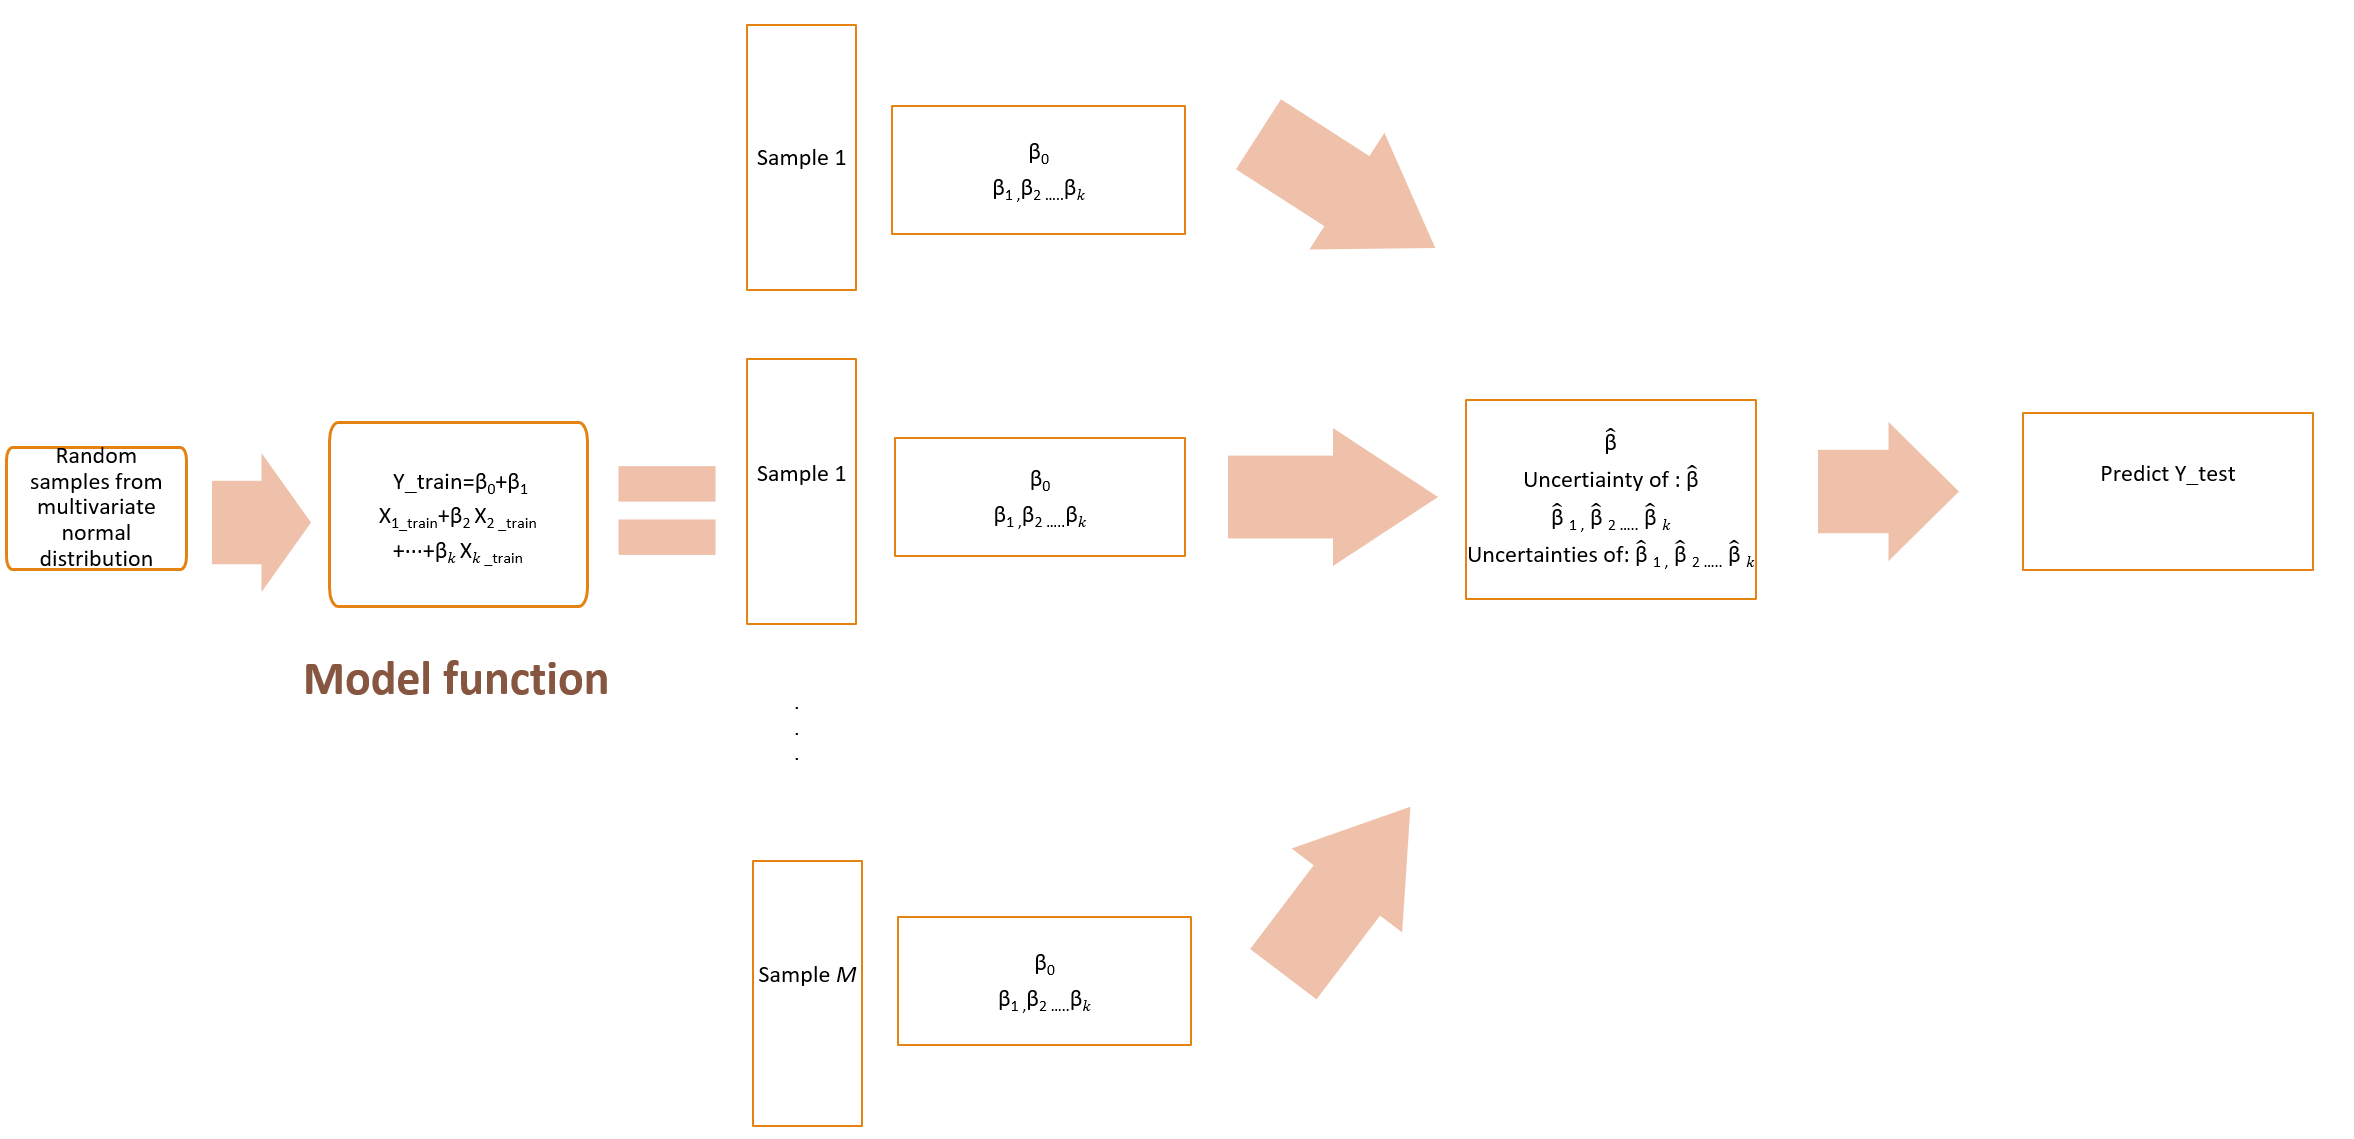

Function `draw_random_samples` obtains list *ind* of *draws* samples from multivariate normal distribution, where amplitudes are means and their uncertainties are standard deviations. These samples are matrices, with shape same as *X_train* and they are stored in the list *drawn_samples*.

In [ ]:
intercept_mean=[None]*len(sorted_values_amp)
coefs_mean=[None]*len(sorted_values_amp)
Uy_intercept=[None]*len(sorted_values_amp)
Uy_coefs=[None]*len(sorted_values_amp)

for k in range(len(sorted_values_amp)):
    def draw_random_samples(draws):   
        ind=[np.zeros(X_train[k].shape)]*draws
        for i in range(draws):
            r=np.random.randn(*X_train[k].shape)
            ind[i]=X_train[k]+r*(np.sqrt(UX_train[k]))
        return ind
    drawn_samples=draw_random_samples(1000)
    intercept=np.zeros((len(drawn_samples)))
    coefs=np.zeros((len(drawn_samples),X_train[k].shape[1]))
    model_wls=[None]*len(drawn_samples)
    for i in range(len(drawn_samples)):
        model_wls[i]=LinearRegression()
        
        model_wls[i].fit(drawn_samples[i],y_train)
        intercept[i]=model_wls[i].intercept_
        coefs[i]= model_wls[i].coef_
    #mean value - best estimate
    intercept_mean[k]=np.mean(intercept,axis=0) 
    coefs_mean[k]=np.mean(coefs,axis=0) 
    sum2=0
    sum1=0
    for s in range(len(drawn_samples)):
        sum2=sum2+np.dot((intercept[s]-intercept_mean[k]),(intercept[s]-intercept_mean[k]))
        sum1=sum1+((coefs[s]-coefs_mean[k]))**2
    Uy_intercept[k]=(1/(len(drawn_samples)-1))*sum2
    Uy_coefs[k]=(1/(len(drawn_samples)-1))*sum1                   


In [ ]:
Uy_coefs[0].shape

In [ ]:
y_MC_predict=[None]*len(sorted_values_amp)
for i in range(len(sorted_values_amp)):
    #check sample weight
    y_MC_predict[i]=intercept_mean[i]+np.sum(coefs_mean[i]*X_test[i],axis=1)
    print("R score for the sensor",num_of_sensor[i],"is:", r2_score(y_test,y_MC_predict[i]),"and MSE error is:", metrics.mean_squared_error(y_test, y_MC_predict[i]))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')
def sensor_predict(i):
    plt.figure(figsize=(15,7))
    plt.plot(np.arange(0,len(y_test),1),y_test,'o',label="True",)
    plt.plot(np.arange(0,len(y_test),1),y_MC_predict[i],'x',label ="Predicted - MC")
    plt.axhline(y=38,label="Nominal value",color="red")
    plt.legend()
    num_of_sensor=['Power [kW]', 'Force [kN]', 'A_ges_vibr', 'Schlagzahl [1/min]','A_ACTpos [mm]', 'L_ACTpos [mm]', 'R_ACTpos [mm]','SBA_ActPos [mm]', 'A_ACT_Force [kN]', 'DB_ACT_Force [kN]','L_NOMpos [mm]', 'R_NOMpos [mm]', 'INDA_NOMpos [deg]','A_NOMpos [mm]', 'Frc_Volt', 'IP_ActPos [mm]', 'IP_NomPos','RamRetract_ActSpd [rpm]', 'ForgingBox_Temp', 'TMP_Ind_U1 [°C]','TMP_Ind_F [°C]', 'W2 Durchfluss [l]', 'W1 Durchfluss [l]','L1.R_B41 [bar]']
    plt.xlabel("Test data") 
    plt.ylabel("External diameter [mm]") 
    plt.title(num_of_sensor[i])

interact(sensor_predict,i=widgets.IntSlider(min=0, max=24, step=1))    

# Bayesian statistical models

Because the outcome of the following work is not certain and it is not relied on some previous knowledge, only one sensor will be considered. Based on the knowledge gained from WLS and Monte Carlo, it will be sensor that measures force.The observed data, that we want to predict is the external diameter of the part at 200 mm from the left. The nominal value is 38 mm. It is stored as variable *y*.

In [ ]:
def draw_random_samples(draws):   
        ind=[np.zeros(X_train[1].shape)]*draws
        for i in range(draws):
            r=np.random.randn(*X_train[1].shape)
            ind[i]=X_train[1]+r*(np.sqrt(UX_train[1]))
        return ind

Data from *drawn_samples* will be scaled using *StandardScaler*. To be consistent with forms of functions in PyMC3, *y_train* will be inserted into *X_train_scale* as first column for every sample.

In [ ]:
list1=[None]*sorted_values_amp[0].shape[1]
for i in range(sorted_values_amp[0].shape[1]):
    list1[i]="Column"+str(i)
    

In [ ]:
#force
scale = StandardScaler()
X_train_force=[None]*len(drawn_samples)
X_train_scale=[None]*len(drawn_samples)
for i in range(len(drawn_samples)):
    X_train_force[i]=pd.DataFrame(drawn_samples[i])
    X_train_scale[i] = scale.fit_transform(X_train_force[i])
    X_train_scale[i]=pd.DataFrame(X_train_scale[i])
    X_train_scale[i].columns=list1
    X_train_scale[i].insert(0, "Diameter", y_train.values, allow_duplicates = False)
UX_test_scale=scale.fit_transform(UX_test[1])
UX_train_scale=scale.fit_transform(UX_train[1])
X_test_scale=scale.fit_transform(X_test[1])

Then, for every sample, Bayesian statistical linear model is specified. We are interested in predicting outcomes *y* (external diameter at 200 mm from the left) as normally-distributed observations with an expected value *µ* that is a linear function of  predictor variables. Predictor variables (columns) from *X_train_scale* will be taken into account for every sample: $X_{1}, X_{2}.....$.
The outcome *y* for one sample is:

$$y ∼ N (µ, σ^2)$$
and 
$$µ = α + β_{1}X_{1} + β_{2}X_{2}+......$$
where *α* is the intercept, and $β_{i}$
is the coefficient for covariate $X_{i}$, while *σ* represents the observation error.


Since we are constructing a Bayesian model, the unknown variables in the model must be assigned a prior
distribution. We choose zero-mean normal priors with variance of 3 for the intercept and  0.001 for other regression coefficients. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for σ.

$$α ∼ N (38,3)$$
$$βi ∼ N (0, 0.001)$$
$$σ ∼ |N (0, 0.5)|$$

[1]

In [ ]:
#force
traces=[None]*len(drawn_samples) #
model_rand=[None]*len(drawn_samples) #list of model objects,one model for every sample
for i in range(len(drawn_samples)):
    with pm.Model() as model_rand[i]: 
        alpha = pm.Normal('alpha', mu=38, sigma=5)
        beta = pm.Normal('beta', mu=0, sigma=0.001,shape=X_train_scale[i].shape[1]) # shape argument to denote it as a vector-valued parameter of size 10
        sigma = pm.HalfNormal('sigma',0.5)
        mu = alpha + pm.math.dot(beta, (X_train_scale[i]).T) #Having defined the priors, the next statement creates the expected value mu of the outcomes, specifying 
        #the linear relationship:
        #mu = alpha + beta[0]*X1 + beta[1]*X2+....beta[9]*X2
        
        # the sampling distribution of the outcomes in the dataset.
        #special case of a stochastic variable that we call an observed stochastic, and represents the
        #data likelihood of the model.
        Diameter = pm.Normal('Diameter', mu=mu, sigma=sigma, observed=X_train_scale[i]['Diameter'])
         # Normal constructor to create a random variable to use as a normal prior. 
        # "Diameter"- The first argument is always the name of the random variable, 
        # which should almost always match the name of the Python variable being assigned to
        # mu, the mean, and sd, the standard deviation, which we assign hyperparameter values for the model. 
        traces[i] = pm.sample(2000,target_accept=0.9) #trace object containing 10 samples of posteriors for alpha,beta,sigma for every sample of X 

Samples in *traces* are collected by No-UTurn Sampler (NUTS). NUTS is especially useful on models that have many continuous parameters, a situation where other MCMC algorithms work very slowly. It takes advantage of information about where regions of
higher probability are, based on the gradient of the log posterior-density. This helps it achieve dramatically faster convergence on large problems than traditional sampling methods achieve. PyMC3 relies on Theano to analytically compute model gradients via automatic differentation of the posterior density. NUTS also has several self-tuning strategies for adaptively setting the tunable parameters of Hamiltonian Monte Carlo. [1]

In [ ]:
plt.style.use('seaborn-darkgrid')

A posterior plot for one trace can be created using `traceplot`.

In [ ]:
from pymc3 import traceplot
pm.traceplot(traces[0])

The left column consists of a smoothed histogram of the marginal posteriors of each stochastic random variable. The right column contains the samples of the Markov chain plotted in sequential order. 

The summary function provides a text-based output of common posterior statistics:

In [ ]:
from pymc3 import summary
pm.summary(traces[0])

In [ ]:
traces_df=[None]*len(traces)
X_train_scale=[None]*len(drawn_samples)
for i in range(len(traces)):
    traces_df[i]=pd.DataFrame(traces[i])
    traces_df[i].to_csv("Traces"+"i"+".csv")
    X_train_scale[i].to_csv("X_train"+"i"+".csv")
X_test_scale.to_csv("X_test.csv")
y_test.to_csv("y_test.csv")

In [ ]:
UA_train.to_csv("UA_train.csv")
UA_test.to_csv("UA_test.csv")

`forestplot` function supports plotting more than one trace.

In [ ]:
pm.forestplot(traces, figsize=(10, 1000))

Another option of plotting several traces in a same plot is to use `densityplot`. This plot is similar to a `forestplot`, but we get truncated KDE plots (by default 95% credible intervals) grouped by variable names together with a point estimate (by default the mean).

In [ ]:
pm.densityplot(traces, var_names=['alpha'])

## Model averaging


When confronted with more than one model we have several options. One of them is to perform model selection, using for example a given Information Criterion. Model selection is appealing for its simplicity, but we are discarding information about the uncertainty in our models. 

One alternative is to perform model selection but discuss all the different models together with the computed values of a given Information Criterion. 

Another approach is to perform model averaging. The idea is to generate a meta-model (and meta-predictions) using a weighted average of the models. 

### Pseudo Bayesian model averaging

Bayesian models can be weighted by their marginal likelihood, this is known as Bayesian Model Averaging. While this is theoretically appealing, is problematic in practice: on the one hand the marginal likelihood is highly sensible to the specification of the prior, in a way that parameter estimation is not, and on the other computing the marginal likelihood is usually a challenging task. 

An alternative route is to use the values of WAIC (Widely Applicable Information Criterion) or LOO (pareto-smoothed importance sampling Leave-One-Out cross-validation), which we will call generically IC, to estimate weights. We can do this by using the following formula:


$$\frac{e^{0.5 dIC_{i}}}{\sum_{J}^{M}{e^{-0.5*dIC_{j}}}}$$


Where $dIC_{i}$ is the difference between the i-esim information criterion value and the lowest one. Remember that the lowest the value of the IC, the better. 

This approach is called pseudo Bayesian model averaging, or Akaike-like weighting and is an heuristic way to compute the relative probability of each model (given a fixed set of models) from the information criteria values. 

WAIC will be used to compare the models:

In [ ]:
model_dict = dict(zip(model_rand, traces))
comp = pm.compare(model_dict, method='BB-pseudo-BMA')
model_comp=comp

In [ ]:
import arviz as az

In [ ]:
model_comp

We have many columns so let check one by one the meaning of them:

- *WAIC* - contains the values of WAIC. The DataFrame is always sorted from lowest to highest WAIC. The index reflects the order in which the models are passed to this function.

- *pWAIC* - the estimated effective number of parameters. In general, models with more parameters will be more flexible to fit data and at the same time could also lead to overfitting. Thus we can interpret pWAIC as a penalization term, intuitively we can also interpret it as measure of how flexible each model is in fitting the data.

- *dWAIC* - the relative difference between the value of WAIC for the top-ranked model and the value of WAIC for each model. For this reason we will always get a value of 0 for the first model.

- *weight* - can be loosely interpreted as the probability of each model (among the compared models) given the data.

- *SE* - records the standard error for the WAIC computations. The standard error can be useful to assess the uncertainty of the WAIC estimates. Nevertheless, caution need to be taken because the estimation of the standard error assumes normality and hence could be problematic when the sample size is low.

- *dSE* - the standard error of the differences between two values of WAIC. Notice that *SE* and *dSE* are not necessarily the same, the reason is that the uncertainty about WAIC is correlated between models. This quantity is always 0 for the top-ranked model.

- *var_warn* - we have the last column named “warning”. A value of 1 indicates that the computation of WAIC may not be reliable, this warning is based on an empirical determined cutoff value and need to be interpreted with caution.[2]  

Now we are going to use copmuted weights to generate predictions based on the weighted set of models. 

In [ ]:
from pymc3 import compare as comp
ppc_w = pm.sample_posterior_predictive_w(traces, 1000, model_rand,weights=model_comp["weight"].sort_index(ascending=True),progressbar=False)

Prediction can be made also for the lowest-WAIC model:

In [ ]:
ppc_x = pm.sample_posterior_predictive(traces[2], 1000, model_rand[2],progressbar=False)

In [ ]:
mean_w = ppc_w['Diameter'].mean()
hpd_w = pm.hpd(ppc_w['Diameter']).mean(0)

mean = ppc_x['Diameter'].mean()
hpd = pm.hpd(ppc_x['Diameter']).mean(0)

plt.errorbar(mean, 1,xerr=[[mean - hpd[0]]] ,fmt='o', label='model 2')
plt.errorbar(mean_w, 0, xerr=[[mean_w - hpd_w[0]]], fmt='o', label='weighted models')

plt.yticks([])
plt.ylim(-1, 2)
plt.xlabel('Diameter')
plt.legend();

In [ ]:
pm.summary(traces[2])

In [ ]:
hf_a.close()
hf_uap.close()

# References:

[1] John Salvatier, Thomas V. Wiecki, Christopher Fonnesbeck - "Probabilistic Programming in Python using PyMC", July 30, 2015

[2] https://docs.pymc.io/notebooks/model_comparison.html

[3] https://docs.pymc.io/notebooks/model_averaging.html

[4] https://www.stat.ncsu.edu/people/bloomfield/courses/st430/slides/MandS-ch09-sec04-04.pdf

[5] S Eichstädt (PTB) - Material for a Monte Carlo Uncertainty workshop with Jupyter notebooks https://github.com/eichstaedtPTB/MonteCarloHandsOn     

[6] Klauenberg, Katy et al. (2015): „A tutorial on Bayesian Normal linear regression“, Metrologia 52 878

[7] Klauenberg, Katy and Elster, Clemens (2016): „Markov chain Monte Carlo methods: an introductory example“, Metrologia 53 S32

[8] Malengo, Andrea and Pennechi, Francesca (2013): „A weighted total least-squares algorithm for any fitting model with correlated variables“, Metrologia 50 654,

[9] Gleser (1981): Estimation in a Multivariate "Errors in Variables" Regression Model: Large Sample Results, Ann. Stat.
